In [3]:
from features_extraction.database import DOG_EMO_DATABASES
import librosa
import numpy as np
import librosa.display
import matplotlib.pyplot as plt

In [4]:
emot_map = {'hap': 0, 'sad':1, 'ang':2, 'fea':3}
dataset_dir = '/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/'
dataset  ='DOG_EMO'
database = DOG_EMO_DATABASES[dataset](dataset_dir, emot_map=emot_map, 
                                include_scripted = False)
speaker_files = database.get_files()


NUMBER OF FILES: 13



In [5]:
speaker_files['valid']

[('/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/valid/hap_baby_bark_004.wav',
  0),
 ('/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/valid/fea_outside_bark_003.wav',
  3),
 ('/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/valid/ang_noise_bark_000.wav',
  2),
 ('/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/valid/ang_hate_growl_001.wav',
  2),
 ('/Users/seungjinhan/Desktop/AI_WITDOG/data/maltese/valid/ang_car_bark_002.wav',
  2)]

In [7]:
x, sr = librosa.load(speaker_files['valid'][0][0], sr=16000)

In [11]:
def extract_segment(x , duration =3  ,sr = 16000):
    avg_amplitude = np.mean(np.abs(x))*10
    above_avg = np.where(np.abs(x) > avg_amplitude)[0]
    
    segments = []
    end_sample = 0
    for start_sample in above_avg:
        if end_sample < start_sample:
            end_sample = start_sample + duration * sr
            if end_sample < len(x):
                segments.append(x[start_sample:end_sample])
            else:
                #padding
                segments.append(x[start_sample:len(x)])
                return segments
    return segments
x, sr = librosa.load(speaker_files['valid'][0][0], sr=16000)
segs = extract_segment(x)            
print(len(segs))

2


In [12]:
segs[0].shape

(48000,)

In [13]:
def padding(feature, MAX_LEN):
    """
    mode: 
        zero: padding with 0
        normal: padding with normal distribution
    location: front / back
    """
    padding_mode  = 'normal'
    padding_location = 'back'

    length = feature.shape[0]
    if length >= MAX_LEN:
        return feature[:MAX_LEN, :]
        
    if padding_mode == "zeros":
        pad = np.zeros([MAX_LEN - length])
    elif padding_mode == "normal":
        mean, std = feature.mean(), feature.std()*0.05
        pad = np.random.normal(mean, std, (MAX_LEN-length))
    feature = np.concatenate([pad, feature], axis=0) if(padding_location == "front") else \
              np.concatenate((feature, pad), axis=0)
    return feature

pad_seg = padding(segs[0] , 48000)

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

Text(0, 0.5, 'Amplitude')

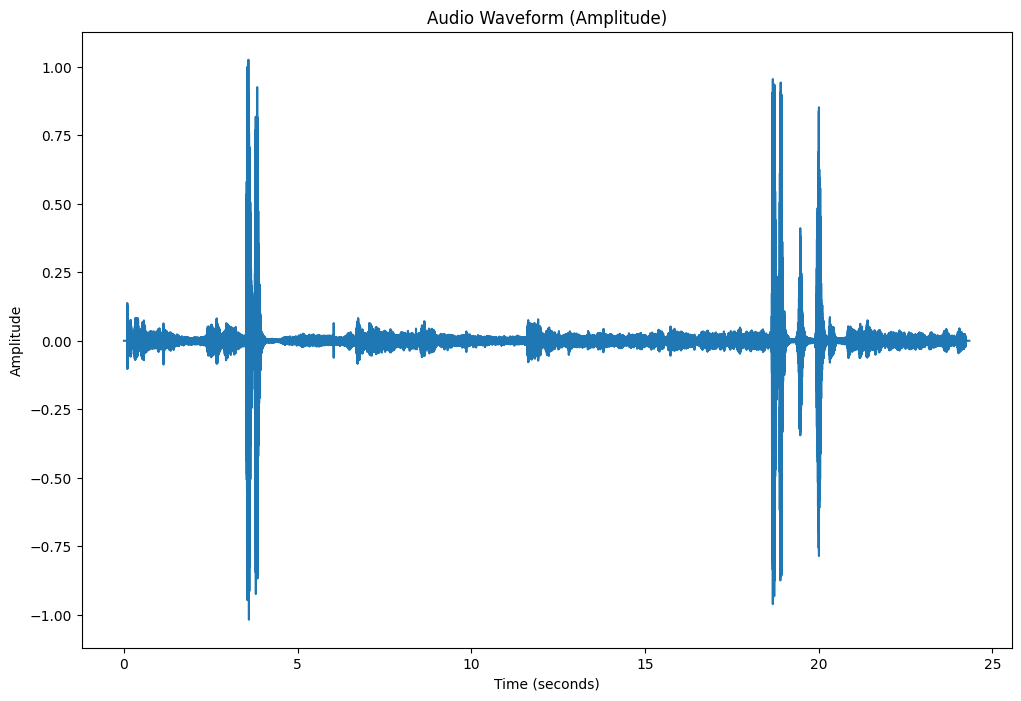

In [15]:
time = np.linspace(0, len(x) / sr, len(x))
start_time = 120000
plt.figure(figsize=(12, 8))
plt.plot(time , x)
plt.title('Audio Waveform (Amplitude)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

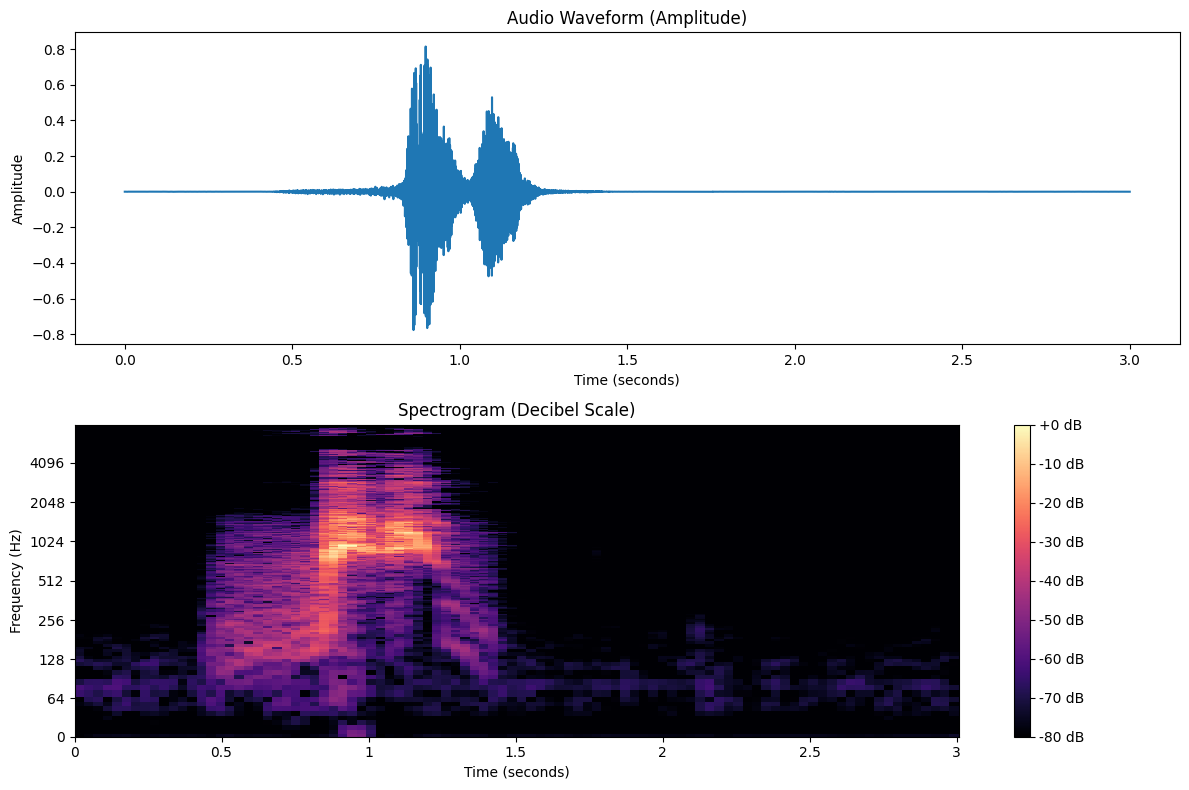

In [5]:
time = np.linspace(0, len(x) / sr, len(x))

# STFT 계산 및 데시벨 스케일 변환
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)

# 파형 플롯 생성 (진폭)
plt.figure(figsize=(12, 8))
plt.subplot(2, 1, 1)  # 2행 1열의 첫 번째 subplot
plt.plot(time, x)
plt.title('Audio Waveform (Amplitude)')
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')

# 데시벨 스케일 파형 플롯 생성
plt.subplot(2, 1, 2)  # 2행 1열의 두 번째 subplot
librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram (Decibel Scale)')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')

plt.tight_layout()  # 서브플롯 간격 조정
plt.show()

In [141]:
import pickle
import torch
features_file = '/Users/seungjinhan/Desktop/bart2text/CA-MSER/features_extraction/features/DOG_EMO_multi.pkl'
with open(features_file, "rb") as fin:
    features_data = pickle.load(fin)
    
    
from data_utils import *
ser_dataset = SERDataset(features_data,
                            val_speaker_id='ost',
                            test_speaker_id='ost',
                            oversample=False
                            )
train_dataset = ser_dataset.get_train_dataset()
train_loader = torch.utils.data.DataLoader(train_dataset , 
                                           batch_size = 1,
                                           shuffle = True)

val_dataset = ser_dataset.get_val_dataset()
test_dataset = ser_dataset.get_test_dataset()

data = next(iter(train_loader))


KeyError: 'ost'

In [3]:
from models.ser_model import Ser_Model

ser_model = Ser_Model()

2024-01-08 15:30:56.432929: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/opt/anaconda3/envs/bark2text/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/anaconda3/envs/bark2text/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(m


<< SER AlexNet Finetuning model initialized >>



/opt/anaconda3/envs/bark2text/lib/python3.9/site-packages/torch/nn/utils/weight_norm.py:30: UserWarning: torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.
  warnings.warn("torch.nn.utils.weight_norm is deprecated in favor of torch.nn.utils.parametrizations.weight_norm.")
Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model: ['lm_head.weight', 'lm_head.bias']
- This IS expected if you are initializing Wav2Vec2Model from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2Model from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2Model were not initialized from the model che

In [4]:
reuslt = ser_model(data['seg_spec'],data['seg_mfcc'],data['seg_audio'] , data['seg_coc'])

In [1]:
import os
save_label= 'ds'
save_path = os.path.join('./result' , save_label + '.pth')

In [2]:
save_path

'./result/ds.pth'